## Load data

In [32]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras

In [33]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
datapath = '/media/sf_VBox_Shared/timeseries/EEGs_Guinea-Bissau_np/'#'/media/windows-share/EEGs_Guinea-Bissau_np/'

In [35]:
condition = '_10seconds_closed.npy'
X_train = np.load(datapath+'X_train'+condition)
y_train = np.load(datapath+'y_train'+condition)
X_val = np.load(datapath+'X_valid'+condition)
y_val = np.load(datapath+'y_valid'+condition)
X_test = np.load(datapath+'X_test'+condition)
y_test = np.load(datapath+'y_test'+condition)

In [36]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

{'Control': 0, 'Epilepsy': 1}


In [37]:
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_test], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [38]:
y_val_binary

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [39]:
print(X_train.shape)

(108, 1280, 14)


In [40]:
num_classes = y_train_binary.shape[1]
print(num_classes)

2


## Generate models

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

In [42]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen, find_architecture

In [43]:
np.random.seed = 321

In [44]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 10,
                                  model_type = 'CNN',
                                  cnn_min_layers=2,
                                  cnn_max_layers=10,
                                 low_lr=2, high_lr=8)

CPU times: user 2.28 s, sys: 64 ms, total: 2.35 s
Wall time: 5.37 s


In [45]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'filters': array([40, 17]), 'regularization_rate': 0.00011562722538178636, 'learning_rate': 3.036321990623559e-06, 'fc_hidden_nodes': 81}
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_41 (BatchNorma(None, 1280, 14)      28          batchnormalization_input_21[0][0]
____________________________________________________________________________________________________
convolution1d_112 (Convolution1D)(None, 1280, 40)      1720        batchnormalization_41[0][0]      
____________________________________________________________________________________________________
batchnormalization_42 (BatchNorma(None, 1280, 40)      80          convolution1d_112[0][0]          
____________________________________________________________________________________________________
activation_94 (Activation)       (None, 1280, 40)    

## Compare models

In [46]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=10,
                                                                                  subset_size=200,
                                                                                  verbose=True)

Train on 108 samples, validate on 20 samples
Epoch 1/10
108/108 [==============================] - 4s - loss: 0.9478 - acc: 0.4907 - val_loss: 1.3247 - val_acc: 0.5000
Epoch 2/10
108/108 [==============================] - 4s - loss: 0.8232 - acc: 0.5185 - val_loss: 1.3123 - val_acc: 0.5500
Epoch 3/10
108/108 [==============================] - 5s - loss: 0.8236 - acc: 0.6019 - val_loss: 1.1777 - val_acc: 0.5500
Epoch 4/10
108/108 [==============================] - 5s - loss: 0.7861 - acc: 0.5833 - val_loss: 1.0049 - val_acc: 0.5500
Epoch 5/10
108/108 [==============================] - 4s - loss: 0.7207 - acc: 0.6481 - val_loss: 0.9728 - val_acc: 0.6500
Epoch 6/10
108/108 [==============================] - 3s - loss: 0.6932 - acc: 0.6389 - val_loss: 0.9784 - val_acc: 0.6500
Epoch 7/10
108/108 [==============================] - 3s - loss: 0.6983 - acc: 0.6296 - val_loss: 1.0042 - val_acc: 0.5500
Epoch 8/10
108/108 [==============================] - 3s - loss: 0.6390 - acc: 0.6389 - val_lo

CPU times: user 836 ms, sys: 0 ns, total: 836 ms
Wall time: 940 ms


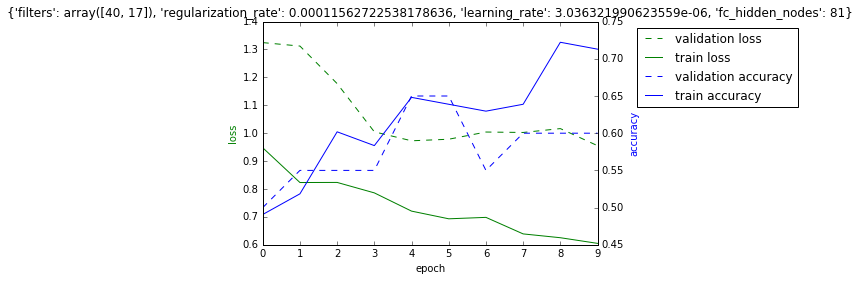

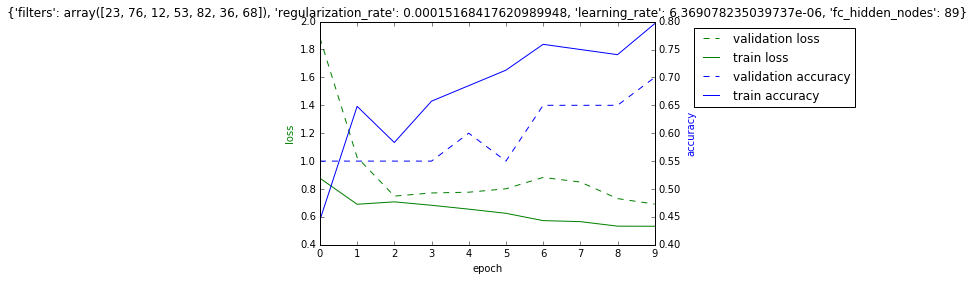

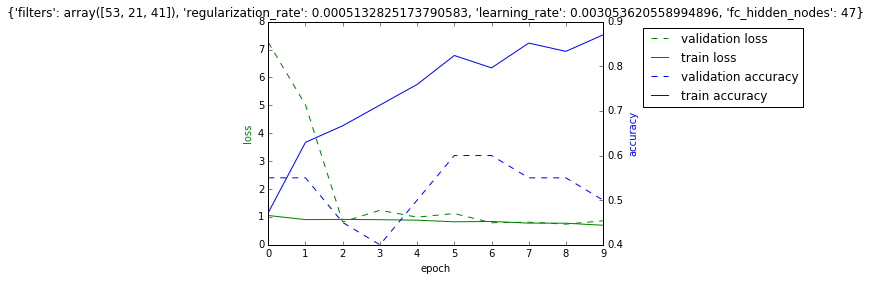

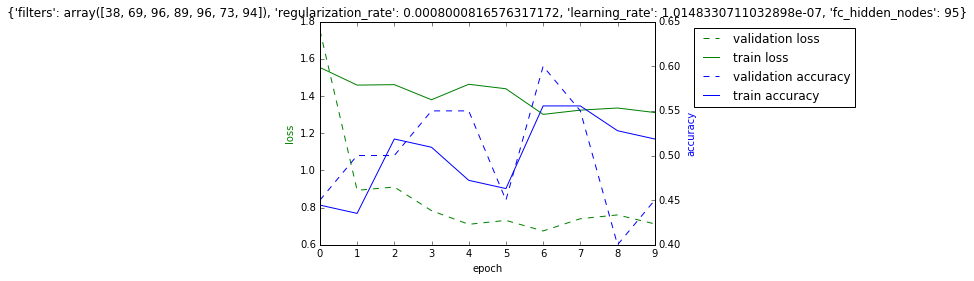

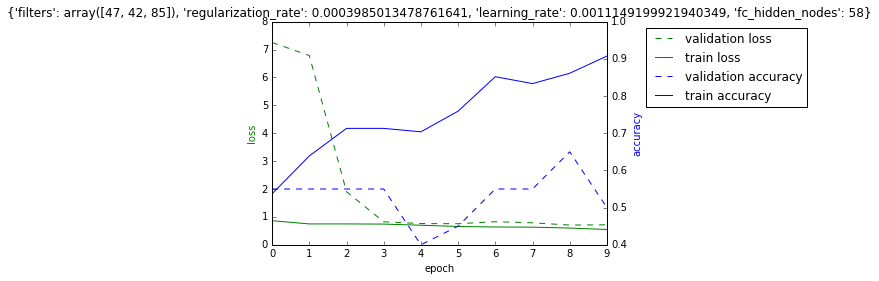

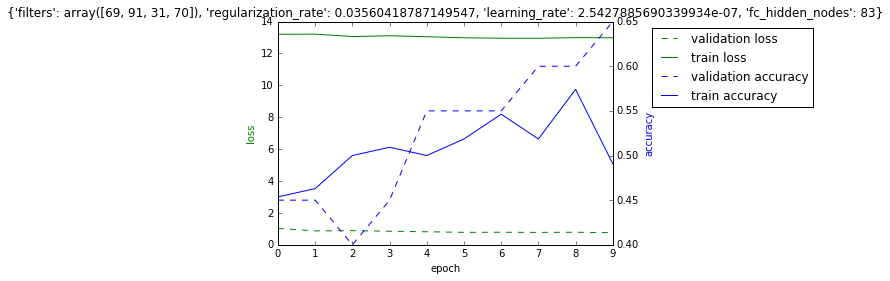

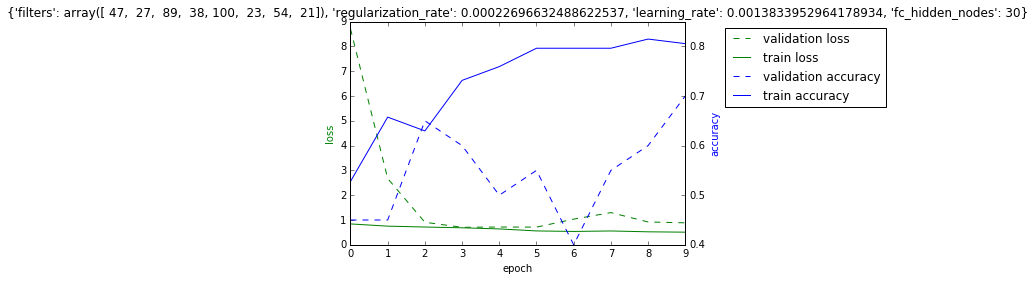

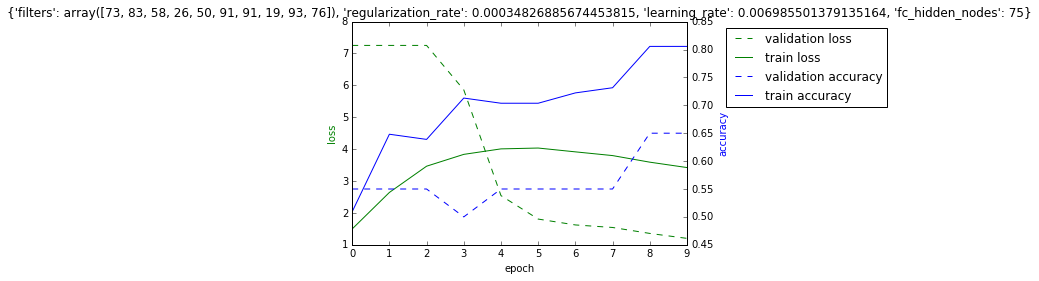

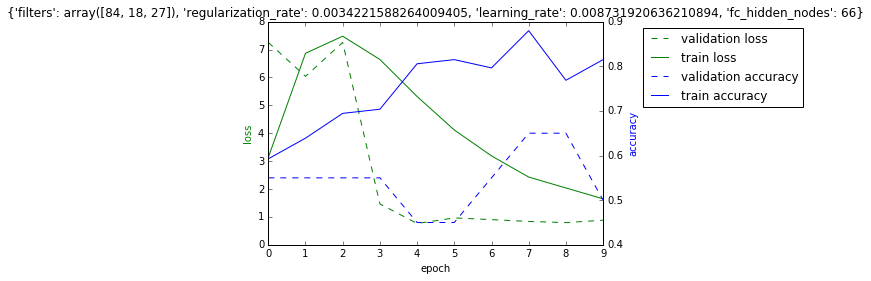

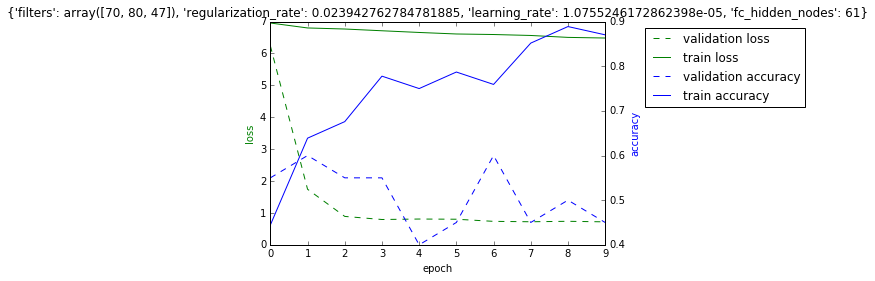

In [49]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [48]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'filters': array([40, 17]), 'regularization_r...",0.712963,0.605128,0.60,0.955236
1,"{'filters': array([23, 76, 12, 53, 82, 36, 68]...",0.796296,0.532907,0.70,0.691917
2,"{'filters': array([53, 21, 41]), 'regularizati...",0.870370,0.699777,0.50,0.858916
3,"{'filters': array([38, 69, 96, 89, 96, 73, 94]...",0.518519,1.311204,0.45,0.712455
4,"{'filters': array([47, 42, 85]), 'regularizati...",0.907407,0.548812,0.50,0.716640
5,"{'filters': array([69, 91, 31, 70]), 'regulari...",0.490741,12.987745,0.65,0.759351
6,"{'filters': array([ 47, 27, 89, 38, 100, 2...",0.805556,0.509066,0.70,0.886137
7,"{'filters': array([73, 83, 58, 26, 50, 91, 91,...",0.805556,3.422679,0.65,1.201437
8,"{'filters': array([84, 18, 27]), 'regularizati...",0.814815,1.646914,0.50,0.881204
9,"{'filters': array([70, 80, 47]), 'regularizati...",0.870370,6.485119,0.45,0.719782


In [ ]:
models

## Train the best model for real

In [50]:
best_model_index = np.argmax(val_accuracies)
#best_model_index = np.argmax(val_losses)
#best_model_index = 1

In [ ]:
import theano
theano.config.mode

In [51]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

1 CNN {'filters': array([23, 76, 12, 53, 82, 36, 68]), 'regularization_rate': 0.00015168417620989948, 'learning_rate': 6.369078235039737e-06, 'fc_hidden_nodes': 89}


In [53]:
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'], best_params['regularization_rate'])
best_model_copy = best_model
print(best_model_index, best_model_types, best_params)

1 CNN {'filters': array([23, 76, 12, 53, 82, 36, 68]), 'regularization_rate': 0.00015168417620989948, 'learning_rate': 6.369078235039737e-06, 'fc_hidden_nodes': 89}


In [54]:
nr_epochs = 10
datasize = X_train.shape[0]#1000
history = best_model_copy.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary), batch_size=20)

Train on 108 samples, validate on 20 samples
Epoch 1/10
108/108 [==============================] - 8s - loss: 0.5581 - acc: 0.7407 - val_loss: 0.6940 - val_acc: 0.7000
Epoch 2/10
108/108 [==============================] - 8s - loss: 0.4900 - acc: 0.8426 - val_loss: 0.7413 - val_acc: 0.7000
Epoch 3/10
108/108 [==============================] - 9s - loss: 0.4997 - acc: 0.8056 - val_loss: 0.7258 - val_acc: 0.7500
Epoch 4/10
108/108 [==============================] - 8s - loss: 0.4723 - acc: 0.8426 - val_loss: 0.7167 - val_acc: 0.6000
Epoch 5/10
108/108 [==============================] - 8s - loss: 0.4057 - acc: 0.9167 - val_loss: 0.8082 - val_acc: 0.6500
Epoch 6/10
108/108 [==============================] - 8s - loss: 0.4663 - acc: 0.8148 - val_loss: 0.8142 - val_acc: 0.7000
Epoch 7/10
108/108 [==============================] - 8s - loss: 0.4090 - acc: 0.8889 - val_loss: 0.7569 - val_acc: 0.7000
Epoch 8/10
108/108 [==============================] - 8s - loss: 0.3817 - acc: 0.9167 - val_lo

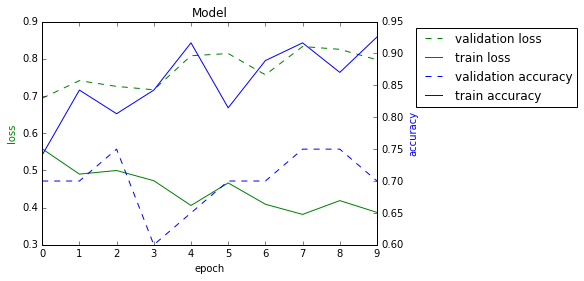

In [55]:
find_architecture.plotTrainingProcess(history)

## Inspect model predictions

In [56]:
datasize = X_val.shape[0]
best_model_copy.predict_proba(X_val[:datasize,:,:],batch_size=1)

20/20 [==============================] - 1s     


array([[ 0.00311034,  0.99688965],
       [ 0.6155237 ,  0.3844763 ],
       [ 0.64030606,  0.35969394],
       [ 0.07064946,  0.92935055],
       [ 0.21815152,  0.78184849],
       [ 0.32976073,  0.67023927],
       [ 0.3837277 ,  0.61627233],
       [ 0.0458601 ,  0.95413989],
       [ 0.39910251,  0.60089749],
       [ 0.74690384,  0.25309616],
       [ 0.29720366,  0.70279634],
       [ 0.35820162,  0.64179838],
       [ 0.49189407,  0.50810593],
       [ 0.36185431,  0.63814569],
       [ 0.59876722,  0.40123278],
       [ 0.54875064,  0.45124939],
       [ 0.72455394,  0.27544603],
       [ 0.63225698,  0.36774305],
       [ 0.62552023,  0.37447977],
       [ 0.59095198,  0.40904799]])

In [ ]:
best_model_copy.summary()

In [ ]:
from keras import backend as K

# with a Sequential model
get_dens_layer_output = K.function([best_model_copy.layers[0].input, K.learning_phase()],
                                  [best_model_copy.layers[0].output])
layer_output = get_dens_layer_output([X_val, 0])[0]

In [ ]:
layer_output.shape

In [ ]:
layer_output.mean(axis=(0,1))

In [ ]:
layer = best_model.layers[0]
for w in layer.get_weights():
    print(w.shape)

## See if we can overfit on a small train set

In [ ]:
params = models[0][1]
print(params)
small_model = modelgen.generate_CNN_model(X_train.shape, num_classes, params['filters'], params['fc_hidden_nodes'],
                                  0.01, #params['learning_rate'], 
                                        regularization_rate=0)
small_model.summary()

In [ ]:
small_model.evaluate(X_val, y_val_binary)

In [ ]:
nr_epochs = 100
datasize = 20
history = small_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary), batch_size=10)

## Test on Testset

In [ ]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))

In [ ]:
best_model.get_config()[0]